In [1]:
# imports
from torch.utils.data import Dataset, DataLoader, IterableDataset
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import torch
import pandas as pd
import json
import torchvision.transforms as transforms
import random
import torch.nn as nn
import torchvision
from tqdm import tqdm
import warnings
import EarlyStopping
from Resnext50 import Resnext50
import BigEarthNetConfig
import BigEarthNetDataset

Uncomment line to download and extract dataset

In [2]:
# !wget -P ./root "https://cloud.dfki.de/owncloud/index.php/s/TwrjNFYpTCEdeKB/download"
# !unzip ./root/download
# !tar -xvzf "./AAI WS2022/bens2.tar.gz"


Uncomment line to create environment and install required depenancies

In [3]:
# conda env create -f environment.yml


In [4]:

BigEarthNetlabels = BigEarthNetConfig.BigEarthNetlabels
BigEarthNetLabelNames = BigEarthNetConfig.BigEarthNetLabelNames

Create Training, Validation and Test data sets 

In [5]:
def getFilePath(dirName, fileName):
    path = './netscratch/siddamsetty/kosovo_files/{}/{}_{}'.format(
        dirName, dirName, fileName)
    return path

# Merge RGB bands and return numpy image array


def getNumpyImageCv2(dirName):
    blue = cv2.imread(getFilePath(dirName, "B02.tif"),
                      cv2.IMREAD_UNCHANGED)
    blue = (blue-np.min(blue))/(np.max(blue)-np.min(blue))
    green = cv2.imread(getFilePath(
        dirName, "B03.tif"), cv2.IMREAD_UNCHANGED)
    green = (green-np.min(green))/(np.max(green)-np.min(green))
    red = cv2.imread(getFilePath(dirName, "B04.tif"),
                     cv2.IMREAD_UNCHANGED)
    red = (red-np.min(red))/(np.max(red)-np.min(red))
    return cv2.resize(cv2.merge([red, green, blue]), dsize=(224, 224))


def loadJson(dirName):
    path = './netscratch/siddamsetty/kosovo_files/{}/{}_labels_metadata.json'.format(
        dirName, dirName)
    with open(getFilePath(dirName, "labels_metadata.json")) as json_data:
        return json.load(json_data)


fileList = os.listdir(path='./netscratch/siddamsetty/kosovo_files/')

valSplit = int(np.floor(0.2*len(fileList)))
testSplit = valSplit
trainSplit = len(fileList) - valSplit - testSplit
train_set, val_set, test_set = torch.utils.data.random_split(
    fileList, [trainSplit, valSplit, testSplit])


def save(name, datset):
    if not os.path.exists("./data/"+name):
        os.makedirs("./data/"+name)
    lablesList = np.zeros(shape=(len(datset), 20), dtype=np.object_)
    for index, dirName in enumerate(datset):
        image = getNumpyImageCv2(dirName)*255
        # print(np.shape(image))
        cv2.imwrite("./data/"+name+"/"+dirName+'.jpg', image)
        labelMetadata = loadJson(dirName)
        labels = labelMetadata.get('labels')
        lablesList[index, 0] = dirName
        for label in labels:
            if BigEarthNetlabels.get(label) is not None:
                lablesList[index, BigEarthNetlabels.get(label)+1] = 1
    np.savetxt("./data/"+name+'/labels.csv',
               lablesList, delimiter=",", fmt="%s")


uncomment below lines to generate dataset again

In [6]:
# save("train",train_set)
# save("val",val_set)
# save("test",test_set)


Creating Dataset and Dataloader class for training

In [7]:
print("Initializing Datasets and Dataloaders...")

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

valDataSet = BigEarthNetDataset.BigEarthNetDataset(
    data_path='./data/val', label_filename="labels.csv", transform=transforms.ToTensor(),target_transform= train_transform)

trainDataSet = BigEarthNetDataset.BigEarthNetDataset(
    data_path='./data/train', label_filename="labels.csv", transform=transforms.ToTensor(),target_transform= train_transform)

testDataSet = BigEarthNetDataset.BigEarthNetDataset(
    data_path='./data/test', label_filename="labels.csv")   

dataloaders_dict = {"train": DataLoader(trainDataSet, batch_size=32, shuffle=True, num_workers=4), "val": DataLoader(
    valDataSet, batch_size=32, shuffle=True, num_workers=4), "test": DataLoader(testDataSet, batch_size=32, shuffle=True, num_workers=4)}


Initializing Datasets and Dataloaders...


Visualizing Random sample with labels

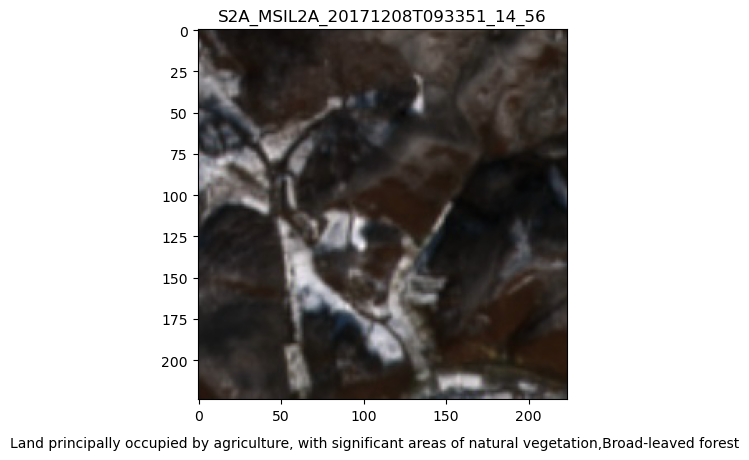

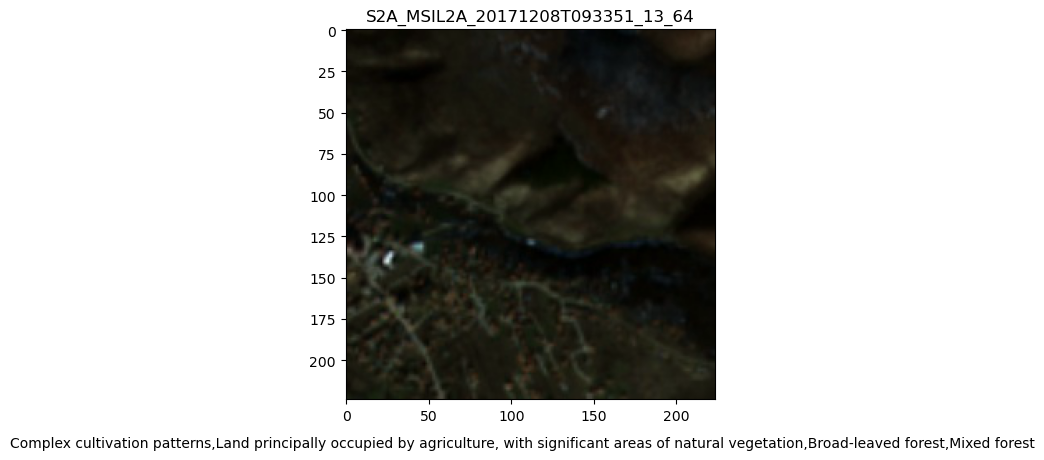

In [8]:

for index in random.sample(range(0, testDataSet.__len__()), 2):
    image, labels = testDataSet[index]
    plt.title(testDataSet.getName(index))
    lables = testDataSet.getLables(index=index)
    plt.figtext(0.5, 0.01, lables, ha="center")
    plt.imshow(image)
    plt.show()

# todo: show lables along with image


In [9]:
device = torch.device("cpu")

In [10]:
# Initialize the model


model = Resnext50(len(BigEarthNetlabels))
# Switch model to the training mode
model.train()

Resnext50(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): 

In [11]:
criterion = torch.nn.BCELoss()

In [12]:
# from sklearn.metrics import precision_score, recall_score, f1_score

# # Use threshold to define predicted labels and invoke sklearn's metrics with different averaging strategies.


# def calculate_metrics(pred, target, threshold=0.5):
#     pred = np.array(pred > threshold, dtype=float)
#     return {'micro/precision': precision_score(y_true=target, y_pred=pred, average='micro'),
#             'micro/recall': recall_score(y_true=target, y_pred=pred, average='micro'),
#             'micro/f1': f1_score(y_true=target, y_pred=pred, average='micro'),
#             'macro/precision': precision_score(y_true=target, y_pred=pred, average='macro'),
#             'macro/recall': recall_score(y_true=target, y_pred=pred, average='macro'),
#             'macro/f1': f1_score(y_true=target, y_pred=pred, average='macro'),
#             'samples/precision': precision_score(y_true=target, y_pred=pred, average='samples'),
#             'samples/recall': recall_score(y_true=target, y_pred=pred, average='samples'),
#             'samples/f1': f1_score(y_true=target, y_pred=pred, average='samples'),
#             }

In [13]:
batch_size = 32
max_epoch_number = 13
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [14]:
# model.load_state_dict(torch.load("checkpoint.pt"))
# model.eval()
# model.train()

In [15]:
early_stopping = EarlyStopping.EarlyStopping(verbose=True, path="checkpoint.pt")

In [16]:
from utils import calculate_metrics


warnings.filterwarnings('ignore')

epoch = 0
iteration = 0
test_freq = 7
save_freq = 1

resultF1 = 0

while True:
    batch_losses = []
    for index,imgsAndTargets in enumerate(tqdm(dataloaders_dict.get("train"))):
        imgs ,targets = imgsAndTargets
        imgs, targets = imgs.to(device), targets.to(device)

        optimizer.zero_grad()

        model_result = model(imgs)
        loss = criterion(model_result, targets)

        batch_loss_value = loss.item()
        loss.backward()
        optimizer.step()

        batch_losses.append(batch_loss_value)

        if iteration % test_freq == 0:
            model.eval()
            with torch.no_grad():
                model_result = []
                targets = []
                for index,imgsAndBatchTargets in enumerate(tqdm(dataloaders_dict.get("val"))):
                    imgs, batch_targets = imgsAndBatchTargets
                    imgs = imgs.to(device)
                    model_batch_result = model(imgs)
                    model_result.extend(model_batch_result.cpu().numpy())
                    targets.extend(batch_targets.cpu().numpy())

            result = calculate_metrics(
                np.array(model_result), np.array(targets))
            resultF1 = result.get("macro/f1")
            print("epoch:{:2d} iter:{:3d} test: "
                  "micro f1: {:.3f} "
                  "macro f1: {:.3f} "
                  "samples f1: {:.3f}".format(epoch, iteration,
                                              result['micro/f1'],
                                              result['macro/f1'],
                                              result['samples/f1']))

            model.train()
        iteration += 1

    loss_value = np.mean(batch_losses)
    print("epoch:{:2d} iter:{:3d} train: loss:{:.3f}".format(
        epoch, iteration, loss_value))
    early_stopping(resultF1, model)
    if early_stopping.early_stop:
        break
    epoch += 1
    if max_epoch_number < epoch:
        break


  2%|▏         | 1/46 [00:30<23:10, 30.90s/it]

epoch: 0 iter:  0 test: micro f1: 0.465 macro f1: 0.111 samples f1: 0.438


 17%|█▋        | 8/46 [01:22<07:28, 11.80s/it]

epoch: 0 iter:  7 test: micro f1: 0.677 macro f1: 0.091 samples f1: 0.564


 33%|███▎      | 15/46 [02:13<05:47, 11.20s/it]

epoch: 0 iter: 14 test: micro f1: 0.587 macro f1: 0.096 samples f1: 0.504


 48%|████▊     | 22/46 [03:04<04:27, 11.15s/it]

epoch: 0 iter: 21 test: micro f1: 0.678 macro f1: 0.099 samples f1: 0.573


 63%|██████▎   | 29/46 [03:58<03:17, 11.64s/it]

epoch: 0 iter: 28 test: micro f1: 0.703 macro f1: 0.132 samples f1: 0.609


 78%|███████▊  | 36/46 [04:49<01:52, 11.24s/it]

epoch: 0 iter: 35 test: micro f1: 0.693 macro f1: 0.135 samples f1: 0.603


 93%|█████████▎| 43/46 [05:40<00:33, 11.16s/it]

epoch: 0 iter: 42 test: micro f1: 0.728 macro f1: 0.173 samples f1: 0.630


100%|██████████| 46/46 [05:50<00:00,  7.62s/it]


epoch: 0 iter: 46 train: loss:0.167
score is 0.17306706473838032 and val_loss is 0.17306706473838032
Validation acc increased (0.000000 --> 0.173067).  Saving model ...


  9%|▊         | 4/46 [00:40<09:09, 13.08s/it]

epoch: 1 iter: 49 test: micro f1: 0.725 macro f1: 0.179 samples f1: 0.635


 24%|██▍       | 11/46 [01:32<06:40, 11.44s/it]

epoch: 1 iter: 56 test: micro f1: 0.673 macro f1: 0.167 samples f1: 0.608


 37%|███▋      | 17/46 [01:57<02:27,  5.08s/it]